In [1]:
import re
import json
import uuid
import glob
import pickle
import sys
import os
import math
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
from numpy import array
from pprint import pprint
import re
import scipy.stats as stat
from os.path import basename
import string
import pandas as pd
import numpy as np
import pyLDAvis
from empath import Empath
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from pycebox.ice import ice, ice_plot
import operator
from nltk import stem
from nltk.stem.snowball import *
from nltk.stem import PorterStemmer
import dask

# Enable logging for gensim - optional
import logging
logging.basicConfig(filename='lda_model.log',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Should the need arise to delete one of the keys in the dictionary
# source: https://stackoverflow.com/questions/49532089/how-to-remove-a-word-in-lda-analysis-by-gensim

'''
# assume the word 'b' is to be deleted, put its id in a variable
del_ids = [k for k,v in dictionary.items() if v=='b']

# remove unwanted word ids from the dictionary in place
dictionary.filter_tokens(bad_ids=del_ids)

# load corpus from your file
corpusMm = gensim.corpora.MmCorpus('MmCorpusTest.mm')
# convert corpus to a dense array, transpose because by default documents would be columns
np_corpus = gensim.matutils.corpus2dense(corpusMm, corpusMm.num_terms, num_docs=corpusMm.num_docs).T
# delete columns for specified tokens, transpose back afterwards
np_corpus = np.delete(np_corpus, del_ids, 1).T
# convert array to corpus
new_corpus = gensim.matutils.Dense2Corpus(np_corpus)
'''

"\n# assume the word 'b' is to be deleted, put its id in a variable\ndel_ids = [k for k,v in dictionary.items() if v=='b']\n\n# remove unwanted word ids from the dictionary in place\ndictionary.filter_tokens(bad_ids=del_ids)\n\n# load corpus from your file\ncorpusMm = gensim.corpora.MmCorpus('MmCorpusTest.mm')\n# convert corpus to a dense array, transpose because by default documents would be columns\nnp_corpus = gensim.matutils.corpus2dense(corpusMm, corpusMm.num_terms, num_docs=corpusMm.num_docs).T\n# delete columns for specified tokens, transpose back afterwards\nnp_corpus = np.delete(np_corpus, del_ids, 1).T\n# convert array to corpus\nnew_corpus = gensim.matutils.Dense2Corpus(np_corpus)\n"

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

In [6]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(40,60), "font.size":8,"axes.labelsize":10})
RANDOM_STATE = 420
N_JOBS=8

In [7]:
def empathize(text, category):
    return(lexicon.analyze(text, categories=[category], normalize=True))

In [8]:
def setting_training_test(dataframe, startdate, splitdate):
    #start_date = pd.datetime(startdate)
    ParentingAfter2012 = dataframe.loc[dataframe['created_utc'] > start_date]
    #separate the training and test data
    #split_date = pd.datetime(splitdate)
    df_training = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] <= split_date]
    df_test = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] > split_date]
    return df_training, df_test

In [9]:
def create_dad(dataframe):
    
    dataframe['DadBody']= dataframe.body.str.match('dad here|I am a dad|I\'m a dad|I am a father|father here|I\'m a father|I am a SAHD|I`m a SAHD|I was a SAHD|I am a stay-at-home father|I\'m a stay-at-home father|I was a stay-at-home father|I was a stay-at-home dad|I was a sahd')
    dataframe['DadAuthor'] = dataframe.author.str.contains('dad|daddy|dada|father', na=False)
    
    return dataframe

In [10]:
def create_mom(dataframe):
    
    dataframe['MomBody'] = dataframe.body.str.match('I\'m a mum|I am a mum|mum here|mom here|I am a mom|I\'m a mom|I am a mother|mother here|I\'m a mother| I am a stay-at-home mom|I\'m a stay-at-home mom|I was a stay-at-home mom|I was a sahm')
    dataframe['MomAuthor'] = dataframe.author.str.contains('mom|mother|mama|mum', na=False)

    
    return dataframe

In [11]:
def create_two_gender_df(dataframe):
    
    dataframe['Gendered'] = (dataframe.DadBody>0) | (dataframe.DadAuthor>0) | (dataframe.MomBody>0) | (dataframe.MomAuthor>0)
    
    return dataframe

In [12]:
def create_throwaway_df(dataframe):
    dataframe['body'] = dataframe['body'].str.lower()
    dataframe['author'] = dataframe['author'].str.lower()
    dataframe['ThrowAuth'] = dataframe.author.str.contains('thrw|throwaway|throw|thrw|thraway', na=False)

    dataframe['ThrowBody'] = dataframe.body.str.match('this is a throwaway|I am using a throwaway|I\'m using a throwawy')

    return dataframe

In [13]:
#Prepare the IV's from dataframe
#add throwaway variable
def prepare_data_for_models(dataframe):
    dataframe_piv = pd.pivot_table(dataframe, index= 'author', aggfunc= 'mean')
    #setting the users of more than one subreddit
    #for example, only r/Daddit and r/Mommit
    dataframe_piv['DM'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting==0)
    dataframe_piv['PD'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.daddit>0) & (dataframe_piv.Mommit==0)
    dataframe_piv['PM'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.daddit==0)
    dataframe_piv['PMD'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting>0)
    
    dataframe_piv['Dad'] = (dataframe_piv.DadBody>0) | (dataframe_piv.DadAuthor>0)
    dataframe_piv['Dad'] = dataframe_piv['Dad']*1
    dataframe_piv['Dad'].fillna(0, inplace=True)
    dataframe_piv['Dad'] = dataframe_piv['Dad'].astype('int')
    
    dataframe_piv['Mom'] = (dataframe_piv.MomBody>0) | (dataframe_piv.MomAuthor>0)
    dataframe_piv['Mom'] = dataframe_piv['Mom']*1
    dataframe_piv['Mom'].fillna(0, inplace=True)
    dataframe_piv['Mom'] = dataframe_piv['Mom'].astype('int')
    
    dataframe_piv['Gendered'] = (dataframe_piv.Mom>0) ^ (dataframe_piv.Dad>0)
    
    #dataframe_piv['Gendered'] = dataframe_piv.mask(dataframe_piv.Gendered>0)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered']*1
    dataframe_piv['Gendered'].fillna(0, inplace=True)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered'].astype('int')
    
        
    dataframe_piv['Throwaway'] = (dataframe_piv.ThrowAuth>0) | (dataframe_piv.ThrowBody>0)
    
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway']*1
    dataframe_piv['Throwaway'].fillna(0, inplace=True)
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway'].astype('int')
    
    return dataframe_piv

In [14]:
def tfidf_topic(dataframe):
    corpus = dataframe.body.tolist()

    Processed_commands = Remove_Punct_Stem(corpus) 

    #texts = Processed_commands
    texts = Processed_commands
    #texts = '-'.join(documents)
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token]+=1

    tokenized = [[token for token in text if frequency[token]>1]for text in texts]

    wordfreq = {}
    for text in texts:
        for token in text:
            wordfreq[token]=frequency[token]  

    sorted_word = sorted(wordfreq.items(), key=operator.itemgetter(1))

    print(sorted_word[-10:])
    from gensim.models import TfidfModel
    from gensim.corpora import Dictionary
    dct = Dictionary(texts)
    corpus = [dct.doc2bow(line) for line in texts]
    model = TfidfModel(corpus)

    topWords = {}
    corpus_tfidf = model[corpus]
    for doc in corpus_tfidf:
        for iWord, tf_idf in doc:
            if iWord not in topWords:
                topWords[iWord] = 0

            if tf_idf > topWords[iWord]:
                topWords[iWord] = tf_idf

    wordimportance = []
    for i, item in enumerate(sorted(topWords.items(), key=lambda x: x[1], reverse=True), 1):
        wordimportance.append((dct[item[0]],item[1]))
        print("%2s: %-13s %s" % (i, dct[item[0]], item[1]))
        if i == 100: break
    return wordimportance, sorted_word

In [15]:
def Remove_Punct_Stem(documents):
    processed = []
    tokenizer = RegexpTokenizer(r'\w+')
    for document in documents:
        stop = stopwords.words('english')
        intermediate = [i for i in document if i not in stop]
        intermediate = tokenizer.tokenize(str(intermediate))
        # FIXME: using other stemmers also to know quality of each stemmed text
        lanste = LancasterStemmer()
        intermediate = [lanste.stem(i) for i in intermediate]
        processed.append(intermediate)
    return processed

In [16]:
def Preprocess(text):
    
    lower_text = []
            
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops and len(w)>=3]
    
    for line in text:
        lower_text.append(line.lower().split())
   
    text = " ".join(text)
    
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^A-Za-z0-9^\/+-=]", " ", text)
    text = re.sub(r"gt;", " ", text)
    text = re.sub(r"gt"," ", text)
    text = re.sub(r"&gt"," ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"!.,:"," ",text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"http://","",text)
    text = re.sub(r"www.","",text)
    text = re.sub(r"http\S+", "", text)

    
    ## Stemming
    text = text.split()
    #print(text[0])
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    #print(text[0])
    stemmed_tokenized_words = Tokinization(text)
    
    return stemmed_tokenized_words


In [17]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [18]:
def Tokinization(document):
    document = "".join(document)
    tokenizer = RegexpTokenizer(r'\w+')
    intermediate = tokenizer.tokenize(document)

    return intermediate

In [19]:
# The source for this is from here:
# https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
def get_p_values(model, X):
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    return p_values

In [20]:
# The source for this is from here:
# https://gist.github.com/lqdc/1ea1682ad1214956d95904ebde3134a5
def get_se(X, y, model):
    """StdErr per variable estimation.
    https://en.wikipedia.org/wiki/Ordinary_least_squares
    """
    MSE = np.mean((y - model.predict(X).T)**2)
    # numerically unstable below with openblas if rcond is less than that
    var_est = MSE * np.diag(np.linalg.pinv(np.dot(X.T, X), rcond=1e-10))
    SE_est = np.sqrt(var_est)
    return SE_est

def decision(coefs, X, intercept):
    return np.dot(X, coefs) + intercept

def get_probs(model, X, SE_est, z=1.96):
    """Estimate CI given data, StdErrors and model."""
    coefs = np.ravel(model.coef_)
    upper = coefs + (z * SE_est)
    lower = coefs - (z * SE_est)

    prob = 1. / (1. + np.exp(-decision(coefs, X, model.intercept_)))
    upper_prob = 1. / (1. + np.exp(-decision(upper, X, model.intercept_)))
    lower_prob = 1. / (1. + np.exp(-decision(lower, X, model.intercept_)))

    stacked = np.vstack((lower_prob, upper_prob))
    up = np.max(stacked, axis=0)
    lo = np.min(stacked, axis=0)
    return prob, upper, lower

def get_odd_ratio(model):
    return np.exp(model.coef_[0])

In [21]:
def plot_coefficients(classifier, feature_names, top_features=10):
    #cannot use sparse matrix with ravel()
    coef = classifier.coef_.toarray().ravel()
    print(coef)
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 10))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [22]:
def removeNone(intermediate):
    #remove None Values
    intermediate = ['' if v is None else v for v in intermediate]
    return intermediate

In [23]:
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [24]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    #lemma_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return ' '.join(stemmed_tokens)

In [27]:
RedditCompleteAA = pd.read_pickle('dfamazon.pickle')
RedditCompleteGH = pd.read_pickle('GoogleHome_Sub.pickle')
RedditCompleteAAGH = RedditCompleteAA.append(RedditCompleteGH)

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [28]:
RedditCompleteAAGH['Throwaway_User'] = RedditCompleteAAGH.author.str.contains('thrw|throwaway|throw|thrw|thraway')

In [29]:
RedditCompleteAAGH['Throwaway_Body'] = RedditCompleteAAGH.body.str.contains('this is a throwaway account|I am using a throwaway account|I am using a throwaway|I\'m using a throwaway|I\'m using a throwaway account|throwaway because|throwaway account because')

In [30]:
RedditCompleteAAGH['Throwaway'] = RedditCompleteAAGH.Throwaway_User | RedditCompleteAAGH.Throwaway_Body

In [31]:
RedditCompleteAAGH.Throwaway.value_counts()

False    109780
True     155   
Name: Throwaway, dtype: int64

In [38]:
RedditCompleteAAGH.columns

Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'index', 'link_id', 'name', 'parent_id',
       'removal_reason', 'score', 'score_hidden', 'subreddit', 'ups',
       'Throwaway_User', 'Throwaway_Body', 'Throwaway'],
      dtype='object')

In [37]:
columns = ['bot_posts_subreddit', 'call_intercome', 'chess_misc_not_clear','code_skills_share','subreddit_removed_submissions']
RedditCompleteAAGH.drop(columns, inplace=True, axis=1)

In [33]:
len(RedditCompleteAAGH.index)

109935

# Mean TF-IDF for Throwaway and Control Responses

In [39]:
#This is to be run the first time around.
#We next need to read the saved document
#'like','people','sound','remove','get','would','one','know','really','think','noise','time','even','also'

l = ['\d+', '[^A-Za-z0-9^\/+-=]', 'dtype', 'dtype object', 'gt;', 
     'gt', '&gt;', '\s{2,}', '!.,:','http://', 'www.','.com','http\S+','\.',',','!','\/','\'s',"'"]
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
stop = stopwords.words('english')
stemmer = SnowballStemmer('english')
porter_stemmer = stem.PorterStemmer()
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

df = RedditCompleteAAGH.copy()
df = df.drop_duplicates(subset='body',keep='first')
df = df.dropna(subset=['body'])
#removing punctuation
print('removing punctuation...')
df['clean_body'] = df['body'].str.lower()
df.clean_body = df.clean_body.replace('|'.join(l), ' ', regex=True)

df.clean_body = df.clean_body.str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop))

print(df.clean_body.head())

df.clean_body = df.clean_body.apply(stem_sentences)
print(df.clean_body.head())

df.clean_body =df.clean_body.apply(lambda x: stemmer.stem(x))

print('after stemming')
print(df.clean_body.head())

df['tokenized_clean_body']= df.clean_body.apply(tokenizer.tokenize)

print('after tokenization')
print(df.tokenized_clean_body.head())

df['Throwaway_User'] = df['Throwaway_User'].fillna(value=0)

removing punctuation...
0    haa   beat                                                                                                                                                                             
1                                                                                                                                                                                           
2    value put web-connected computer first-rate voice control pop-quality speaker    amazon says noise-cancellation good enough echo understand speech playing music  wonder running water 
3    think  get invite  going apply reward points towards                                                                                                                                   
5    agree; lets see facilitate integration amazon devices                                                                                                                                  
Name: clean_body, dtype: object

In [40]:
df.to_pickle('AAGH_Cleaned.pkl')

In [55]:
df.subreddit.unique()

array(['amazonecho', 'googlehome'], dtype=object)

In [117]:
df.tail(10)

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,index,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body
116733,NaN,BCnSTL,None,None,Will it function like a GH speaker? Can you cast to it or just ask it questions?\nRe-read the article &amp; answered my own question - Chromecast functionality included.,0,2017-08-31 21:25:17,None,NaN,NaT,0,NaN,t3_6x6hot,NaN,t3_6x6hot,NaN,2,NaN,googlehome,NaN,False,False,False,function like gh speaker cast ask question re-read articl amp; answer question - chromecast function includ,"[function, like, gh, speaker, cast, ask, question, re, -read, articl, amp, ;, answer, question, -, chromecast, function, includ]"
116734,NaN,coda_,None,None,what the...,0,2017-08-31 21:26:01,None,NaN,NaT,0,NaN,t3_6x9qsc,NaN,t1_dme9t1u,NaN,1,NaN,googlehome,NaN,False,False,False,,[]
116735,NaN,twobrain,None,None,you have to clear the cache in one of the apps. i forget which one. google it. i had to do this when i first got gh.,0,2017-08-31 21:29:41,None,NaN,NaT,0,NaN,t3_6wpkb4,NaN,t3_6wpkb4,NaN,1,NaN,googlehome,NaN,False,False,False,clear cach one app forget one googl first got gh,"[clear, cach, one, app, forget, one, googl, first, got, gh]"
116736,NaN,BeerBrats,None,None,"As if anyone is going to remember the exact phrases to use 10,000 ""skills"" on the Echo, let alone 50. They are nothing more than a stumbling block for Alexa. Google Home just does what you ask no matter how you phrase it. And yes, I have both.",0,2017-08-31 21:32:09,None,NaN,NaT,0,NaN,t3_6x2uak,NaN,t1_dme2fh5,NaN,0,NaN,googlehome,NaN,False,False,False,anyon go rememb exact phrase use skill echo let alon noth stumbl block alexa googl home ask matter phrase y,"[anyon, go, rememb, exact, phrase, use, skill, echo, let, alon, noth, stumbl, block, alexa, googl, home, ask, matter, phrase, y]"
116737,NaN,Alwayssunnyinarizona,mod,SmartThings | Chromecast,Read in the voice of Captain Kirk it's way more entertaining.,0,2017-08-31 21:34:41,None,NaN,NaT,0,NaN,t3_6x9qsc,NaN,t1_dme9t1u,NaN,1,NaN,googlehome,NaN,False,False,False,read voic captain kirk way entertain,"[read, voic, captain, kirk, way, entertain]"
116738,NaN,casey_h6,None,None,Bad bot,0,2017-08-31 21:36:19,None,NaN,NaT,0,NaN,t3_6x9qsc,NaN,t1_dme9t1u,NaN,2,NaN,googlehome,NaN,False,False,False,bad bot,"[bad, bot]"
116739,NaN,G19Gen3,None,None,Kitchen.,0,2017-08-31 21:45:32,None,NaN,NaT,0,NaN,t3_6x6hot,NaN,t1_dme8qa8,NaN,2,NaN,googlehome,NaN,False,False,False,kitchen,[kitchen]
116740,NaN,BeerBrats,None,None,"It definitely does turn the tv on. It's not the Home or Chromecast, it's your tv. I tell my Google Home to ""play Stranger Things on Netflix"" and it turns the tv on, goes on Netflix and starts where I left off on Stranger Things. Same with YouTube. Either your tv doesn't support another device turning it on, or you haven't enabled it to allow outside devices to control power in your settings.",0,2017-08-31 21:55:41,None,NaN,NaT,0,NaN,t3_6wrq58,NaN,t1_dmah1us,NaN,1,NaN,googlehome,NaN,False,False,False,definit turn tv home chromecast tv tell googl home play stranger thing netflix turn tv goe netflix start left stranger thing youtub either tv support anoth devic turn enabl allow outsid devic control power set,"[definit, turn, tv, home, chromecast, tv, tell, googl, home, play, stranger, thing, netflix, turn, tv, goe, netflix, start, left, stranger, thing, youtub, either, tv, support, anoth, devic, turn, enabl, allow, outsid, devic, control, power, set]"
116741,NaN,funkyb,None,None,"Way late to this but I've been doing this for months and it works fine. But good news: hook just added a native Google home/assistant app. Like, I just got the email and set it up 30 minutes ago. So now you can take ifttt out of the loop and it's much more responsive.",0,2017-08-31 22:34:14,None,NaN,NaT,0,NaN,t3_6qesm0,NaN,t3_6qesm0,NaN,1,NaN,googlehome,NaN,F

In [116]:
print(df.clean_body)

0         haa beat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
1                                                                                                                                                                                                                       

In [42]:
df.tokenized_clean_body

0         [haa, beat]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1         []                                                                                                                                                                                                                                                                                                             

# Vectorization

In [43]:
X = df.tokenized_clean_body

In [44]:
%%time

import operator

texts = X

from collections import defaultdict
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token]+=1

tokenized = [[token for token in text if frequency[token]>1]for text in texts]

wordfreq = {}
for text in texts:
    for token in text:
        wordfreq[token]=frequency[token]  

sorted_word = sorted(wordfreq.items(), key=operator.itemgetter(1))

print('getting the top words using word freqency')
print(sorted_word[-30:])

getting the top words using word freqency
[('make', 7617), ('need', 7668), ('also', 7909), ('go', 8232), ('time', 8380), ('thing', 8409), ('music', 8823), ('want', 8827), ('think', 8836), ('-', 9077), ('tri', 9170), ('amazon', 9711), ('set', 9786), ('light', 10152), ('turn', 10386), ('devic', 10459), ('app', 11547), ('say', 12551), (':', 13208), ('play', 13601), ('one', 13640), ('would', 14144), ('get', 15460), ('like', 16086), ('alexa', 18058), ('home', 18863), ('echo', 18882), ('work', 20769), ('use', 23167), ('googl', 25010)]
CPU times: user 1.38 s, sys: 22.4 ms, total: 1.4 s
Wall time: 1.41 s


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

vectorizer = TfidfVectorizer(ngram_range=(3,4))
X = vectorizer.fit_transform(df['clean_body'])
features_by_gram = defaultdict(list)
for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))
top_n = 20
for gram, features in features_by_gram.items():
    top_features = sorted(features, key=lambda x: x[1], reverse=False)[:top_n]
    top_features = [f[0] for f in top_features]
    print('{}-gram top:'.format(gram), top_features)

3-gram top: ['say hey googl', 'googl play music', 'googl home app', 'say ok googl', 'say alexa turn', 'hey googl play', 'live room light', 'use googl home', 'say alexa play', 'turn live room', 'hey googl turn', 'ok googl play', 'googl home devic', 'alexa turn light', 'googl home play', 'get googl home', 'messag pose to', 'googl home work', 'smart thing hub', 'googl home use']
4-gram top: ['turn live room light', 'say hey googl play', 'say hey googl turn', 'alexa turn live room', 'reddit messag pose to', 'say ok googl play', 'ie utf amp qid', 'qid amp sr amp', 'say ok googl turn', 'utf amp qid amp', 'amp qid amp sr', 'tp link smart plug', 'amp sr amp keywords', 'say turn live room', 'np reddit messag pose', 'say alexa turn light', 'use googl play music', 'ok googl send feedback', 'ref sr ie utf', 'sr ie utf amp']


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(ngram_range=(1,1))
x = v.fit_transform(df['clean_body'])

terms = v.get_feature_names()
sums = x.sum(axis=0)

data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

tfidf_df = pd.DataFrame(data, columns=['Terms','Score'])

In [47]:
tfidf_df.sort_values(by=['Score'])

,Terms,Score
13384,loaderror,0.010239
16608,pageant,0.010239
13239,lilo,0.018558
25957,williamarlsimac,0.022298
23486,tideguid,0.024526
9165,getepisodedetail,0.025198
13444,loginfo,0.025198
25302,voicerespons,0.025198
25300,voiceprocessmedia,0.025198
9194,gettvshow,0.025198


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(ngram_range=(3,4))
x = v.fit_transform(df['clean_body'])

terms = v.get_feature_names()
sums = x.sum(axis=0)

data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

tfidf_df = pd.DataFrame(data, columns=['Terms','Score'])

In [49]:
tfidf_df.sort_values(by=['Score'])

,Terms,Score
2039372,said ask question pm,0.007720
150341,amp stitch pm detail,0.007720
1793417,play song sunshin amp,0.007720
150340,amp stitch pm,0.007720
1793416,play song sunshin,0.007720
2014160,road pm detail locat,0.007720
2014161,road pm detail play,0.007720
2014201,road take home,0.007720
2014202,road take home countri,0.007720
2005454,ride pm detail play,0.007720


# LLR for the two different documents

I have adapted code written in R to calculate LLR for tokens with their TFIDF scores. This is the source of the code:
https://tm4ss.github.io/docs/Tutorial_4_Term_extraction.html

In [56]:
import math
#import numpy
import numpy as np
# import sparse module from SciPy package 
from scipy import sparse
# import uniform module to create random numbers
from scipy.stats import uniform

In [57]:
import dask.dataframe as dd

In [58]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


In [59]:
def test_incremental_coo(x_shape, y_shape):

    shape = x_shape, y_shape

    dense = np.random.random(shape)
    mat = IncrementalCOOMatrix(shape, np.float64)

    for i in range(shape[0]):
        for j in range(shape[1]):
            mat.append(i, j, dense[i, j])

    coo = mat.tocoo()

    assert np.all(coo.todense() == sp.coo_matrix(dense).todense())
    assert coo.row.base is mat.rows
    assert coo.col.base is mat.cols
    assert coo.data.base is mat.data

In [60]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
Throwaway = df[df['subreddit']=='amazonecho']
Complete_Throw = Throwaway['clean_body']
Throwaway_vect = TfidfVectorizer(ngram_range=(1,3))
Throw_DTM = Throwaway_vect.fit_transform(Complete_Throw)
Throw_tf_idf = Throwaway_vect.vocabulary
Throw_tf_idf_features = Throwaway_vect.get_feature_names()
Throw_DTM_df = wm2df(Throw_DTM, Throw_tf_idf_features)

CPU times: user 16.2 s, sys: 4.05 s, total: 20.3 s
Wall time: 21.5 s


In [61]:
Throw_DTM.shape

(57314, 1275078)

In [ ]:
#Sum the tokens throughout all the documents we have
ThrowSum = Throw_DTM_df.sum()
ThrowSum =  pd.DataFrame(ThrowSum, columns=['value'])
#In order to work on the Throw Token values, we will take a transpose of the datafame
ThrowSumT = ThrowSum.T

In [48]:
ThrowSum.sort_values(by=['value'],ascending=False)

,value
know,1.844943
thank,1.415014
get,1.389190
misophonia,1.388543
really,1.348249
think,1.275107
even,1.248212
time,1.160357
would,1.146847
feel,1.121243


In [49]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
Pseud = df[df['subreddit']=='googlehome']
Complete_Pseud = Pseud['clean_body']
Pseud_vect = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
Pseud_DTM = Pseud_vect.fit_transform(Complete_Pseud)
Pseud_tf_idf = Pseud_vect.vocabulary
Pseud_tf_idf_features = Pseud_vect.get_feature_names()
Pseud_DTM_df = wm2df(Pseud_DTM, Pseud_tf_idf_features)

CPU times: user 23.5 s, sys: 2.16 s, total: 25.6 s
Wall time: 25.9 s


In [50]:
%%time
ControlSum = Pseud_DTM_df.sum()
ControlSum =  pd.DataFrame(ControlSum, columns=['value'])
ControlSumT = ControlSum.T

CPU times: user 7.48 s, sys: 11.6 s, total: 19.1 s
Wall time: 23.2 s


In [51]:
%%time
#Getting the intersection between them
Intersection = list(set(Throw_DTM_df.columns).intersection(set(Pseud_DTM_df.columns)))

CPU times: user 4.87 ms, sys: 12.5 ms, total: 17.3 ms
Wall time: 16.7 ms


In [52]:
a = ThrowSumT[Intersection]
print('done with a')
print(a.columns)
print(a.head())

b = ControlSumT[Intersection]
print('done with b')
print(b.columns)
print(b.head())

c = ThrowSum.sum()
print('done with c')
print('c = ', c.head())

d = ControlSum.sum()
print('done with d')
print('d = ', d.head())


#Now, create the following two variables
#Expected1 = c*(a+b)/(c+d)

#Expected2 = d*(a+b)/(c+d)

Exp1 = (a + b)
Exp2 = (c + d)
Exp3 = Exp1/(Exp2).max()

Expected1 = Exp3.apply(lambda x: x*c)
Expected2 = Exp3.apply(lambda x: x*d)


try:
    t1 = a * np.log((a/Expected1))
except ZeroDivisionError:
    t1 = a * np.log((a/Expected1)+1)

print('t1 = ', t1.head())
print('dimensions for t1:')
print(len(t1.columns))
print(len(t1.index))

try:
    t2 = b * np.log((b/Expected2))
except ZeroDivisionError:
    t2 = b * np.log((b/Expected2)+1)
print('t2 = ', t2.head())
print('dimesions for t2:')
print(len(t2.columns))
print(len(t2.index))

Loglikelihood = 2*(t1+t2)
print('Likelihood dimensions')
print(len(Loglikelihood.columns))
print(len(Loglikelihood.index))
print(Loglikelihood.head())

#Now getting relA, and relB
#relA = (a/c)
#relB = (b/d)

relA = a.apply(lambda x: x/c)
relB = b.apply(lambda x: x/d)

Loglikelihood[relA<relB.all()] = Loglikelihood[relA<relB.all()] * -1

print(Loglikelihood.head())

l22 = Loglikelihood.T

l22 = l22.reindex()

#LLR Throw>Pseudo
LLR_Throw = l22.value.sort_values(ascending=False)[0:25]

#LLR Pseudo>Throw
LLR_Pseud = l22.value.sort_values(ascending=True)[0:25]

done with a
Index(['learned', 'cut', 'could', 'would ask', 'head', 'less', 'breakfast',
       'married', 'want', 'center',
       ...
       'display', 'together', 'god', 'gave', 'general', 'read posts', 'lunch',
       'might actually', 'running', 'online'],
      dtype='object', length=1538)
        learned       cut     could  would ask      head      less  breakfast  \
value  0.097955  0.045174  0.838778  0.048977   0.363804  0.186847  0.11702     

        married      want    center  said think       dad     dark  \
value  0.120769  0.546911  0.145975  0.105758    0.610601  0.20419   

       yeah really  cognitive  get something  extremely loud  experiences  \
value  0.126701     0.149731   0.132538       0.058877        0.103603      

            use  many times  org wiki  even understand  really important  \
value  0.949478  0.143964    0.074866  0.07891          0.126701           

       actually      drug    calmed       job    quiet     super    cannot  \
value  0.63384

In [53]:
LLR_Throw[::-1]

gets better     -6.702532e-05
guilty          -6.616708e-05
city            -6.438445e-05
suffering       -6.068434e-05
thing think     -5.966299e-05
puts            -5.581494e-05
someday         -4.269707e-05
whether         -4.098104e-05
cannot stand    -2.518836e-05
drives insane   -2.483076e-05
combined        -2.290616e-05
relationship    -2.152059e-05
forget          -1.814048e-05
nice            -1.634271e-05
words           -1.382798e-05
habit           -1.323462e-05
member          -1.033138e-05
years ago       -9.558946e-06
hates           -9.483598e-06
fear            -7.179674e-06
someone else    -5.221255e-06
turn volume     -4.569700e-06
try get         -3.974854e-06
reminds         -1.919296e-06
mended          -7.869730e-07
Name: value, dtype: float64

In [54]:
LLR_Pseud

addictive       -1.887728
watch video     -1.841525
noise           -1.840018
gum             -1.824566
could explain   -1.767734
trigger         -1.483976
see             -1.473346
oh              -1.439811
never           -1.434348
noises          -1.434176
love            -1.433761
one             -1.429701
chewing         -1.399647
hearing         -1.381481
music           -1.376719
pretty common   -1.368098
hate            -1.341240
perfect         -1.272283
get             -1.257523
help            -1.244375
would           -1.223930
chew            -1.211503
feel horrible   -1.175433
next            -1.156244
sure            -1.137688
Name: value, dtype: float64

In [1111]:
LLR_Throw.to_csv('Throw_LLR.csv')

In [1112]:
LLR_Pseud.to_csv('Pseud_LLR.csv')

In [62]:
df3 = pd.read_pickle('Mizo_Cleaned.pkl')

In [63]:
df3.head()

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,clean_body,tokenized_clean_body,Throwaway
0,True,sillyrob,None,None,Ive tried it personally not audio tracks but listening to my girlfriend snore on the phone to see if I can take it to no avail Ive found it make me hate the idea of her falling asleep more and more Im not saying this is always the case with sufferers but this has been my experience,0,2012-01-05 06:57:45,None,0.0,NaT,0,t nfydh,t c e puj,t nfydh,NaN,1,False,misophonia,1.0,False,False,ive tried personally audio tracks listening girlfriend snore phone see take avail ive found make hate idea falling asleep im saying always case sufferers experi,"[ive, tried, personally, audio, tracks, listening, girlfriend, snore, phone, see, take, avail, ive, found, make, hate, idea, falling, asleep, im, saying, always, case, sufferers, experi]",False
1,True,Fireplum,None,None,For me it started in my early teenage years as well Like so many others here I have also been diagnosed with the gift of better than average hearing My first trigger was also my father and since back then it has become gradually worse over the yearsI cannot go anywhere without bringing my Zune and noise cancelling headphones If I sleep anywhere where I have to expect other people being around I have to bring ear plugs Actually I always have ear plugs in my purse anyway sometimes noises in social gatherings just get too much It has gotten to the point where I plan every social gathering ahead and have to prepare myself for the noise and have to ask who of my friends is going to be there just so I can take appropriate steps beforehand If I know that someone who is basically a slob is coming I am dreading the gathering from then on out Public transport and things like college are a nightmare for me as is going to the cinema even though I used to love doing all of that and still do I just have to sit through what feels like torture to avoid becoming entirely antisocialI have audio and visual triggers The main visual ones are gum chewing with someones mouth open I cannot stand seeing that even from the corner of my eye The worst audio triggers are chewing loud breathing unless I an trying to fall asleep then it is any audible breathing any kind of noise that is made anywhere close to the throat just nose sniffeling doesnt get to me as much scuffing feet styrofoam this one includes goose bumps and snoring omg snoring Oh and finger and knuckle cracking thats a bad one tooThis disorder or whatever it is classified as makes me feel like a bitch and hypocrite all day since my own noises dont bother me my intake of noise is heightened by my good hearing so no matter how silent someone is its never silent enough and on top of it all its hard to tell your best friends and family to stop breathing so loud It sounds utterly ridiculous Also not helping are the death stares I am shooting at everyone who makes an offending noise I cannot control that stare or my head turning right at them when it happens The rage the stares the frustration it all is involuntary and I wish I could just make it stop With the headphones and ear plugs and telling my friends about misophonia I have taken steps the last couple months to be more social and not let this affect me to the point where I become a hermit But its incredibly hard All it needs is someone in the neighbouring room falling asleep on the couch and starting to snore I will hear it through the closed door and the night is ruined My friends start feeling bad for it and for me and it all goes downhill from there And I am lucky my friends actually acknowledge this being more than just get over it but it still sucks My head is screwed up and I have to make them feel badIt does seem like a lot of sufferers have had similar histories I am also part of a group on F

# LDA Test # 3

In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import os

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [26]:
df = pd.read_pickle('AAGH_Cleaned.pkl')

In [27]:
CompleteThread = []
CompleteThread = df.groupby('link_id')['clean_body'].apply(list)
#running for the rest of the data
processed_threads = []
#creating threads for each of the users
for thread in CompleteThread:
    #Preprocessing each of the threads
    processed_threads.append(Tokinization(thread))

In [28]:
texts = processed_threads

In [29]:
print(texts[0])

['haa', 'beatvalu', 'put', 'web', 'connect', 'comput', 'first', 'rat', 'voic', 'control', 'pop', 'qual', 'speaker', 'amazon', 'say', 'noise', 'cancel', 'good', 'enough', 'echo', 'understand', 'speech', 'play', 'music', 'wonder', 'run', 'watthink', 'get', 'invit', 'go', 'appli', 'reward', 'point', 'towardagree', 'let', 'see', 'facilit', 'integr', 'amazon', 'devtruecompanion', 'app', 'android', 'fireo', 'think', 'unlik', 'integrwouldnt', 'expect', 'kind', 'tech', 'amazon', 'realli', 'curiou', 'look', 'highli', 'unnecessari']


In [30]:
# Get token frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token]+=1

In [31]:
wordfreq = {}
for text in texts:
    for token in text:
        wordfreq[token]=frequency[token]

In [32]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

higherfreq2 = {k:v for k, v in wordfreq.items() if v>5000}  
print(higherfreq2)

{'connect': 5417, 'voic': 5554, 'control': 6930, 'speaker': 5522, 'amazon': 9226, 'say': 11734, 'echo': 17533, 'play': 13019, 'music': 8770, 'get': 14466, 'go': 7465, 'see': 5813, 'app': 10604, 'think': 7062, 'know': 6300, 'could': 6403, 'googl': 23750, 'one': 13009, 'make': 7244, 'want': 8331, 'would': 12848, 'time': 8293, 'tri': 7498, 'use': 21337, 'alexa': 16849, 'room': 5294, 'like': 15536, 'ask': 6720, 'also': 7054, 'set': 9036, 'need': 7199, 'phone': 7194, 'way': 5774, 'thing': 8161, 'devic': 10401, 'someth': 5804, 'turn': 10009, 'switch': 5320, 'work': 18063, 'tv': 6990, 'light': 9704, 'home': 18768, 'command': 5975, 'ifttt': 5344, 'skill': 5245, 'hub': 5299, 'dot': 5745}


In [33]:
import operator
x = higherfreq2
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x)

[('googl', 23750), ('use', 21337), ('home', 18768), ('work', 18063), ('echo', 17533), ('alexa', 16849), ('like', 15536), ('get', 14466), ('play', 13019), ('one', 13009), ('would', 12848), ('say', 11734), ('app', 10604), ('devic', 10401), ('turn', 10009), ('light', 9704), ('amazon', 9226), ('set', 9036), ('music', 8770), ('want', 8331), ('time', 8293), ('thing', 8161), ('tri', 7498), ('go', 7465), ('make', 7244), ('need', 7199), ('phone', 7194), ('think', 7062), ('also', 7054), ('tv', 6990), ('control', 6930), ('ask', 6720), ('could', 6403), ('know', 6300), ('command', 5975), ('see', 5813), ('someth', 5804), ('way', 5774), ('dot', 5745), ('voic', 5554), ('speaker', 5522), ('connect', 5417), ('ifttt', 5344), ('switch', 5320), ('hub', 5299), ('room', 5294), ('skill', 5245)]


In [35]:
dictionary = corpora.Dictionary(texts)
print(len(dictionary))
dictionary.save('AAGH.dict')
print(dictionary)

93331
Dictionary(93331 unique tokens: ['haa', 'beatvalu', 'put', 'web', 'connect']...)


In [36]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('AAGH.mm', corpus)
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


#add the value that you think is a LOW_Value
#this could be done if you think there are too many low TF-IDF values that might be pushing LDA
#in the wrong direction
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
low_value = LOW_Value
low_value_words = []
for bow in corpus:
    low_value_words += [id for id, value in tfidf[bow] if value < low_value]
dictionary.filter_tokens(bad_ids=low_value_words)
corpus = [dictionary.doc2bow(text) for text in texts]

In [37]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

In [38]:
print(id2word[0])

haa


In [39]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('haa', 1), ('beatvalu', 1), ('put', 1), ('web', 1), ('connect', 1), ('comput', 1), ('first', 1), ('rat', 1), ('voic', 1), ('control', 1), ('pop', 1), ('qual', 1), ('speaker', 1), ('amazon', 3), ('say', 1), ('noise', 1), ('cancel', 1), ('good', 1), ('enough', 1), ('echo', 1), ('understand', 1), ('speech', 1), ('play', 1), ('music', 1), ('wonder', 1), ('run', 1), ('watthink', 1), ('get', 1), ('invit', 1), ('go', 1), ('appli', 1), ('reward', 1), ('point', 1), ('towardagree', 1), ('let', 1), ('see', 1), ('facilit', 1), ('integr', 1), ('devtruecompanion', 1), ('app', 1), ('android', 1), ('fireo', 1), ('think', 1), ('unlik', 1), ('integrwouldnt', 1), ('expect', 1), ('kind', 1), ('tech', 1), ('realli', 1), ('curiou', 1), ('look', 1), ('highli', 1), ('unnecessari', 1)]]


In [40]:
%%time

# Build LDA model
#from dask.distributed import Client
from sklearn.externals import joblib
#client = Client(processes=False)             # create local cluster
import os

#by setting the chunksize to about 1/10 of the corpus size, 
#you can maintain the processing time under control while 
#comparing across different chunks of text

chunksize = 1000
passes = 20
workers = 5

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=20, 
                                   random_state=100,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True,
                                   workers=workers)



CPU times: user 2min 42s, sys: 1min 27s, total: 4min 10s
Wall time: 3min 52s


In [41]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"harmoni" + 0.020*"turn" + 0.018*"hub" + 0.016*"use" + 0.016*"work" + '
  '0.014*"tv" + 0.014*"control" + 0.011*"ifttt" + 0.010*"activ" + '
  '0.010*"command"'),
 (1,
  '0.020*"nest" + 0.019*"thermostat" + 0.017*"temperatur" + 0.011*"would" + '
  '0.011*"set" + 0.011*"ecobe" + 0.010*"sensor" + 0.009*"heat" + 0.008*"home" '
  '+ 0.007*"temp"'),
 (2,
  '0.043*"googl" + 0.034*"home" + 0.033*"tv" + 0.033*"cast" + '
  '0.032*"chromecast" + 0.019*"play" + 0.014*"audio" + 0.014*"work" + '
  '0.012*"netflix" + 0.010*"app"'),
 (3,
  '0.019*"use" + 0.015*"devic" + 0.013*"app" + 0.012*"work" + 0.010*"connect" '
  '+ 0.010*"echo" + 0.009*"would" + 0.009*"wifi" + 0.009*"phone" + '
  '0.008*"network"'),
 (4,
  '0.015*"googl" + 0.013*"devic" + 0.008*"bluetooth" + 0.007*"see" + '
  '0.006*"would" + 0.006*"one" + 0.005*"support" + 0.005*"new" + 0.005*"like" '
  '+ 0.004*"home"'),
 (5,
  '0.024*"amp" + 0.016*"nbsp" + 0.003*"code" + 0.003*"i" + 0.002*"esp" + '
  '0.002*"x" + 0.002*"bot" + 0

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.580468964748987

Coherence Score:  0.7173284835355355


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.199154  0.001889  1       1        14.724001
9      0.179208  0.041329  2       1        14.242019
16     0.180707 -0.056078  3       1        11.991775
18     0.192602 -0.099857  4       1        9.674285 
0      0.171792 -0.054064  5       1        9.636024 
15     0.205178  0.062009  6       1        8.963107 
3      0.148675  0.003882  7       1        7.767828 
12     0.143896 -0.011284  8       1        7.378753 
19     0.158430  0.101511  9       1        5.754877 
2      0.167017  0.038679  10      1        4.305165 
1      0.002778 -0.175019  11      1        1.296019 
17     0.019846  0.048629  12      1        1.205707 
4      0.001120  0.021138  13      1        1.011037 
10    -0.176357  0.161653  14      1        0.705396 
11    -0.184405  0.025338  15      1        0.301604 
6     -0.238812 -0.049967  16      1        0.264341 
7     -0.249634 -0.022029  17      1        0.223468 
5     -0.299850 -0.014704  18      1        0.213235 
8     -0.303380  0.010923  19      1        0.181164 
13    -0.317965 -0.033979  20      1        0.160194 , topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
69     Default  23935.000000  googl       23935.000000  30.0000  30.0000
22     Default  12569.000000  play        12569.000000  29.0000  29.0000
916    Default  9331.000000   light       9331.000000   28.0000  28.0000
23     Default  8384.000000   music       8384.000000   27.0000  27.0000
991    Default  18921.000000  home        18921.000000  26.0000  26.0000
910    Default  6524.000000   tv          6524.000000   25.0000  25.0000
12     Default  5649.000000   speaker     5649.000000   24.0000  24.0000
4433   Default  3278.000000   chromecast  3278.000000   23.0000  23.0000
199    Default  15618.000000  alexa       15618.000000  22.0000  22.0000
4511   Default  4184.000000   harmoni     4184.000000   21.0000  21.0000
4861   Default  2923.000000   cast        2923.000000   20.0000  20.0000
628    Default  9777.000000   turn        9777.000000   19.0000  19.0000
14     Default  11343.000000  say         11343.000000  18.0000  18.0000
317    Default  2898.000000   song        2898.000000   17.0000  17.0000
3158   Default  5130.000000   hub         5130.000000   16.0000  16.0000
4820   Default  5185.000000   dot         5185.000000   15.0000  15.0000
915    Default  3941.000000   hue         3941.000000   14.0000  14.0000
768    Default  2175.000000   amp         2175.000000   13.0000  13.0000
2631   Default  5003.000000   skill       5003.000000   12.0000  12.0000
491    Default  3517.000000   bluetooth   3517.000000   11.0000  11.0000
475    Default  9808.000000   devic       9808.000000   10.0000  10.0000
479    Default  2659.000000   spotifi     2659.000000   9.0000   9.0000 
2257   Default  2774.000000   bulb        2774.000000   8.0000   8.0000 
843    Default  17418.000000  work        17418.000000  7.0000   7.0000 
807    Default  3563.000000   audio       3563.000000   6.0000   6.0000 
156    Default  12439.000000  would       12439.000000  5.0000   5.0000 
223    Default  5147.000000   room        5147.000000   4.0000   4.0000 
327    Default  8816.000000   set         8816.000000   3.0000   3.0000 
19     Default  15848.000000  echo        15848.000000  2.0000   2.0000 
316    Default  1849.000000   playlist    1849.000000   1.0000   1.0000 
...        ...           ...   ...                 ...     ...      ... 
22772  Topic20  1.646278      hud         3.258883      5.7537  -7.4497 
1692   Topic20  24.013823     sing        98.400285     5.0261  -4.7696 
1967   Topic20  24.950209     birthday    112.444627    4.9310  -4.7313 
7587   Topic20  4.225773      horoscop    11.935911     5.3982  -6.5070 
20775  Topic20  5.557301      pioneer     18.509078     5.2334  -6.2

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit=100, start=10, step=10):
    """
    You will need to change the chunksize in reference to the size of the corpus. A more detailed explanation can be found here:
    https://miningthedetails.com/blog/python/lda/GensimLDA/
    
    For the Parenting and MensRightrs corpora, I think the chunksize would be around 50,000
    
    Compute c_v coherence for various number of topics
    
    Parameters to change:
    -----------
    chunksize
    workers:
    on big laptop, the total number of cores = 8, so set to 6 (usually n-2)
    on small laptop, the local numeber of cores = 5, so set to 3
    on server, set to 9-10 workers

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    chunksize = 1000
    passes = 20
    workers = 5
    
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics, 
                                   random_state=100,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True,
                                   workers=workers)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        #perplexity_values.append(lda_model.log_perplexity(corpus))
    return model_list, coherence_values

In [45]:
%%time
# Can take a long time to run.

limit = 100
start = 5
step  = 5

model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

CPU times: user 2h 26min 36s, sys: 3h 7min 32s, total: 5h 34min 8s
Wall time: 4h 49min 50s


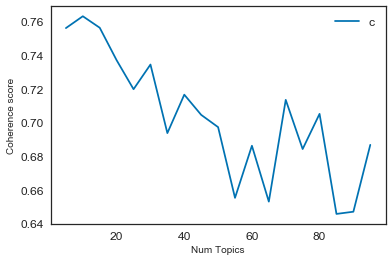

In [46]:
# Show graph
fig = plt.gcf()
limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_models_coherence.jpg')

In [ ]:
%%time
#trying to magnify between 2 and 20
# Can take a long time to run.

limit = 20
start = 2
step  = 2

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

In [ ]:
#taking a closer look @ the numbers under 20
# Show graph
fig = plt.gcf()
limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_models_coherence.jpg')

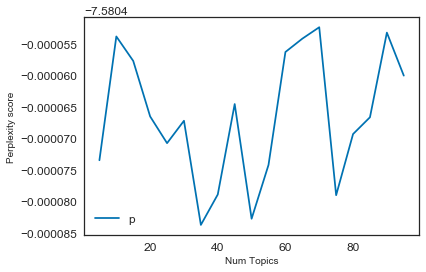

In [47]:
# Show graph
limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [49]:
# Print the coherence scores
coherence = zip(x, coherence_values)
sorted_coherence = sorted(coherence, key=lambda x: x[1], reverse=True)

print(sorted_coherence)

for m, cv in sorted_coherence:
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

[(10, 0.7630568725057888), (15, 0.7562262982411913), (5, 0.7560295479555392), (20, 0.7369391640818729), (30, 0.7343967731653234), (25, 0.7197443753863073), (40, 0.7165009187974043), (70, 0.713426650905972), (80, 0.7051115353236149), (45, 0.7045126599257623), (50, 0.6972288747375466), (35, 0.6936940502482426), (95, 0.6867162584000308), (60, 0.6861877035559718), (75, 0.6842296285662723), (55, 0.6552591332315946), (65, 0.6530184039511935), (90, 0.6470275111297924), (85, 0.6457212220014823)]
Num Topics = 10  has Coherence Value of 0.7631
Num Topics = 15  has Coherence Value of 0.7562
Num Topics = 5  has Coherence Value of 0.756
Num Topics = 20  has Coherence Value of 0.7369
Num Topics = 30  has Coherence Value of 0.7344
Num Topics = 25  has Coherence Value of 0.7197
Num Topics = 40  has Coherence Value of 0.7165
Num Topics = 70  has Coherence Value of 0.7134
Num Topics = 80  has Coherence Value of 0.7051
Num Topics = 45  has Coherence Value of 0.7045
Num Topics = 50  has Coherence Value of

In [62]:
# Print the coherence scores
perplexity = zip(x, perplexity_values)
sorted_perplexity = sorted(perplexity, key=lambda x: x[1], reverse=False)

print(sorted_perplexity)

for m, cv in sorted_perplexity:
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

[(70, -7.648394747070092), (60, -7.648394631987977), (80, -7.648387714765416), (30, -7.648382692540685), (90, -7.648372064287171), (20, -7.648371593686573), (50, -7.648366093635441), (40, -7.648360699647439), (10, -7.648353146474097)]
Num Topics = 70  has Perplexity Value of -7.6484
Num Topics = 60  has Perplexity Value of -7.6484
Num Topics = 80  has Perplexity Value of -7.6484
Num Topics = 30  has Perplexity Value of -7.6484
Num Topics = 90  has Perplexity Value of -7.6484
Num Topics = 20  has Perplexity Value of -7.6484
Num Topics = 50  has Perplexity Value of -7.6484
Num Topics = 40  has Perplexity Value of -7.6484
Num Topics = 10  has Perplexity Value of -7.6484


In [96]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.018*"turn" + 0.017*"light" + 0.015*"work" + 0.015*"use" + 0.014*"hub" + '
  '0.012*"control" + 0.012*"switch" + 0.011*"harmoni" + 0.011*"home" + '
  '0.011*"ifttt" + 0.010*"hue" + 0.008*"tv" + 0.008*"set" + 0.008*"get" + '
  '0.008*"like" + 0.008*"devic" + 0.008*"command" + 0.007*"bulb" + '
  '0.007*"alexa" + 0.007*"one"'),
 (1,
  '0.042*"play" + 0.022*"room" + 0.021*"light" + 0.018*"song" + 0.018*"music" '
  '+ 0.016*"say" + 0.015*"name" + 0.013*"playlist" + 0.013*"work" + '
  '0.011*"spotifi" + 0.010*"turn" + 0.010*"live" + 0.009*"alexa" + '
  '0.009*"group" + 0.008*"one" + 0.008*"googl" + 0.008*"home" + 0.008*"like" + '
  '0.007*"tri" + 0.007*"bedroom"'),
 (2,
  '0.045*"googl" + 0.031*"home" + 0.017*"play" + 0.013*"work" + 0.012*"use" + '
  '0.012*"set" + 0.012*"cast" + 0.011*"tv" + 0.011*"app" + 0.011*"chromecast" '
  '+ 0.010*"phone" + 0.009*"gh" + 0.009*"music" + 0.008*"get" + 0.008*"like" + '
  '0.008*"say" + 0.007*"assist" + 0.007*"us" + 0.007*"hey" + 0.006*"tri"'),
 

In [97]:
optimal_model.num_topics

10

In [98]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.081849 -0.019092  1       1        23.670392
0     -0.120161  0.019093  2       1        21.189688
3     -0.059403  0.006530  3       1        12.819044
6     -0.088431 -0.068055  4       1        12.238755
2     -0.089156  0.059696  5       1        11.103882
4     -0.071258  0.000286  6       1        8.998026 
1     -0.040568  0.030411  7       1        6.601833 
5      0.167287 -0.207054  8       1        2.003934 
7      0.121032  0.073930  9       1        0.828619 
8      0.262507  0.104254  10      1        0.545827 , topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
69     Default  25183.000000  googl      25183.000000  30.0000  30.0000
916    Default  9460.000000   light      9460.000000   29.0000  29.0000
22     Default  11781.000000  play       11781.000000  28.0000  28.0000
255    Default  3850.000000   call       3850.000000   27.0000  27.0000
991    Default  19666.000000  home       19666.000000  26.0000  26.0000
23     Default  7524.000000   music      7524.000000   25.0000  25.0000
843    Default  17157.000000  work       17157.000000  24.0000  24.0000
13     Default  7285.000000   amazon     7285.000000   23.0000  23.0000
12     Default  5647.000000   speaker    5647.000000   22.0000  22.0000
3158   Default  5161.000000   hub        5161.000000   21.0000  21.0000
223    Default  5055.000000   room       5055.000000   20.0000  20.0000
4820   Default  4762.000000   dot        4762.000000   19.0000  19.0000
628    Default  9868.000000   turn       9868.000000   18.0000  18.0000
33553  Default  5040.000000   gh         5040.000000   17.0000  17.0000
8      Default  5344.000000   voic       5344.000000   16.0000  16.0000
14     Default  11361.000000  say        11361.000000  15.0000  15.0000
317    Default  2859.000000   song       2859.000000   14.0000  14.0000
177    Default  1354.000000   number     1354.000000   13.0000  13.0000
4511   Default  4267.000000   harmoni    4267.000000   12.0000  12.0000
19     Default  14297.000000  echo       14297.000000  11.0000  11.0000
768    Default  2151.000000   amp        2151.000000   10.0000  10.0000
382    Default  6783.000000   phone      6783.000000   9.0000   9.0000 
120    Default  4292.000000   account    4292.000000   8.0000   8.0000 
767    Default  4029.000000   name       4029.000000   7.0000   7.0000 
491    Default  3592.000000   bluetooth  3592.000000   6.0000   6.0000 
199    Default  13476.000000  alexa      13476.000000  5.0000   5.0000 
910    Default  6224.000000   tv         6224.000000   4.0000   4.0000 
915    Default  4104.000000   hue        4104.000000   3.0000   3.0000 
4861   Default  2684.000000   cast       2684.000000   2.0000   2.0000 
128    Default  7006.000000   make       7006.000000   1.0000   1.0000 
...        ...          ...    ...               ...      ...      ... 
2236   Topic10  34.036173     fi         334.704857    2.9248  -5.6467 
116    Topic10  7.408160      le         19.816541     4.2267  -7.1715 
67318  Topic10  10.792567     yeelight   40.561675     3.8867  -6.7952 
3493   Topic10  35.189653     canada     446.153485    2.6707  -5.6133 
8      Topic10  102.074447    voic       5344.178353   1.2526  -4.5484 
1744   Topic10  15.456889     french     103.473624    3.3094  -6.4360 
968    Topic10  36.918479     contact    708.284018    2.2565  -5.5654 
8174   Topic10  14.359571     street     90.766940     3.3667  -6.5097 
3333   Topic10  18.937415     imag       184.278394    2.9353  -6.2330 
4260   Topic10  11.991638     unknown    66.803498     3.4931  -6.6899 
525    Topic10  22.416829     busi       313.613005    2.5723  -6.0643 
69     Topic10  114.476390    googl      25183.448154 -0.1830  -4.4337 
128    Topic10  67.795543     make       7006.242838   0.5726  -4.957

In [53]:
count = 0
for LDA_Model in model_list:
    Filename = "LDA_Model."+str(count+1)+".model"
    print(Filename)
    LDA_Model.save(Filename)
    count = count + 1

LDA_Model.1.model
LDA_Model.2.model
LDA_Model.3.model
LDA_Model.4.model
LDA_Model.5.model
LDA_Model.6.model
LDA_Model.7.model
LDA_Model.8.model
LDA_Model.9.model
LDA_Model.10.model
LDA_Model.11.model
LDA_Model.12.model
LDA_Model.13.model
LDA_Model.14.model
LDA_Model.15.model
LDA_Model.16.model
LDA_Model.17.model
LDA_Model.18.model
LDA_Model.19.model


In [99]:
optimal_model.save('optimal_LDA.model')

# Finding topic distributions accross df

In [218]:
#First, get a list of posts, one by one
processed_posts = []
CompletePosts = df['clean_body'].apply(list)
#running for the rest of the data
processed_posts = []
#creating threads for each of the users
for post in CompletePosts:
    #Preprocessing each of the threads
    processed_posts.append(Tokinization(post))
       
new_doc2bow = [dictionary.doc2bow(post) for post in processed_posts]
vector = optimal_model.get_document_topics(new_doc2bow)

#create a list of dictioaries for scores relating to optimum LDA
newdictlist = []
for i in range(0, len(vector)):
    newdictlist.append(dict(vector[i]))

topic_bow = pd.DataFrame(newdictlist)

topic_bow.fillna(0, inplace=True)

In [219]:
topic_bow

,0,1,2,3,4,5,6,7,8,9
0,0.033333,0.033333,0.033333,0.033334,0.699996,0.033333,0.033335,0.033335,0.033334,0.033334
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.000000,0.157595,0.000000,0.000000,0.000000,0.000000,0.491168,0.000000,0.000000,0.325305
3,0.011113,0.011112,0.011113,0.011114,0.011114,0.011113,0.899983,0.011112,0.011112,0.011114
4,0.012504,0.012501,0.012502,0.887476,0.012505,0.012505,0.012502,0.012501,0.012500,0.012505
5,0.050006,0.050004,0.050008,0.050005,0.549946,0.050005,0.050012,0.050001,0.050001,0.050012
6,0.012505,0.012501,0.487817,0.012505,0.012506,0.012501,0.412158,0.012501,0.012500,0.012506
7,0.016670,0.016668,0.016671,0.016668,0.849972,0.016669,0.016673,0.016673,0.016667,0.016670
8,0.033339,0.033339,0.033344,0.033346,0.033340,0.033334,0.699933,0.033342,0.033339,0.033343
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.918163


In [220]:
RedditComplete = df.copy()

In [221]:
#create list of topic names to be 
#columns for the new df
TopicList = []
TopicNum = optimal_model.num_topics

for i in range(0,TopicNum):
    TopicList.append('Topic_' + str(i))

In [222]:
column_indices = topic_bow.columns
new_names = columns
old_names = topic_bow[column_indices]
topic_bow.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [226]:
#leave in place and add the columns together
RedditComplete.reset_index(drop=True, inplace=True)
topic_bow.reset_index(drop=True, inplace=True)
MizoFrame = pd.concat([RedditComplete, topic_bow], axis=1)

In [228]:
MizoFrame.head()

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,index,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,0,ajpatel011235,None,None,haa.. you beat me to it!,0,NaT,None,0.0,None,0,4231803.0,t3_2lhnaj,t1_cluuzgi,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,haa beat,"[haa, beat]",0.033333,0.033333,0.033333,0.033334,0.699996,0.033333,0.033335,0.033335,0.033334,0.033334
1,0,,None,None,,0,NaT,None,0.0,None,0,4231880.0,t3_2lhnaj,t1_cluv7to,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,,[],0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0,Unbathed,None,None,what value do you put on a web-connected computer with first-rate voice control and a pop-quality speaker? \n\namazon says the noise-cancellation is good enough that the echo can understand speech while it is playing music. i wonder how it is with running water.,0,NaT,None,0.0,None,0,4232059.0,t3_2lhnaj,t1_cluvveq,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,valu put web-connect comput first-rat voic control pop-qual speaker amazon say noise-cancel good enough echo understand speech play music wonder run wat,"[valu, put, web, -connect, comput, first, -rat, voic, control, pop, -qual, speaker, amazon, say, noise, -cancel, good, enough, echo, understand, speech, play, music, wonder, run, wat]",0.000000,0.157595,0.000000,0.000000,0.000000,0.000000,0.491168,0.000000,0.000000,0.325305
3,0,ajpatel011235,None,None,"i think so. if i get the invite, i'm going to apply my reward points towards it.",0,NaT,None,0.0,None,0,4232076.0,t3_2lhnaj,t1_cluvxii,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,think get invit go appli reward point toward,"[think, get, invit, go, appli, reward, point, toward]",0.011113,0.011112,0.011113,0.011114,0.011114,0.011113,0.899983,0.011112,0.011112,0.011114
4,0,ursula666,None,None,i agree; lets see if it will facilitate integration with other amazon devices.,0,NaT,None,0.0,None,0,4232813.0,t3_2lhnaj,t1_cluyk4a,t1_cluw2u3,None,1,0,amazonecho,1.0,False,False,False,agree; let see facilit integr amazon dev,"[agree, ;, let, see, facilit, integr, amazon, dev]",0.012504,0.012501,0.012502,0.887476,0.012505,0.012505,0.012502,0.012501,0.012500,0.012505


# Recognizing different topics

In [107]:
#set the nuber of samples you want and how close they are to 
#a specific topic
Sample_Size = 50
Percentage_Closeness = 0.90
#if there are no reddit posts with 90% closeness
Secondary_Closeness = 0.5 

In [108]:
#create a number of empty strings equal to the number of topics in the optimum LDA model
TopicSamples = [[] for i in range(TopicNum)]

In [109]:
#Checking on the numeber of lists
len(TopicSamples)

10

In [124]:
optimal_model.print_topics(num_words=40)

[(0,
  '0.018*"turn" + 0.017*"light" + 0.015*"work" + 0.015*"use" + 0.014*"hub" + 0.012*"control" + 0.012*"switch" + 0.011*"harmoni" + 0.011*"home" + 0.011*"ifttt" + 0.010*"hue" + 0.008*"tv" + 0.008*"set" + 0.008*"get" + 0.008*"like" + 0.008*"devic" + 0.008*"command" + 0.007*"bulb" + 0.007*"alexa" + 0.007*"one" + 0.007*"need" + 0.007*"smartth" + 0.006*"smart" + 0.006*"app" + 0.005*"would" + 0.005*"activ" + 0.005*"thing" + 0.005*"echo" + 0.005*"say" + 0.005*"want" + 0.005*"also" + 0.005*"time" + 0.005*"remot" + 0.005*"go" + 0.004*"wemo" + 0.004*"trigger" + 0.004*"link" + 0.004*"googl" + 0.004*"make" + 0.004*"tri"'),
 (1,
  '0.042*"play" + 0.022*"room" + 0.021*"light" + 0.018*"song" + 0.018*"music" + 0.016*"say" + 0.015*"name" + 0.013*"playlist" + 0.013*"work" + 0.011*"spotifi" + 0.010*"turn" + 0.010*"live" + 0.009*"alexa" + 0.009*"group" + 0.008*"one" + 0.008*"googl" + 0.008*"home" + 0.008*"like" + 0.007*"tri" + 0.007*"bedroom" + 0.007*"station" + 0.006*"ask" + 0.006*"would" + 0.006*"us

In [111]:
#Get 100 random samples for each of the topics in order to understand what each is about
for i in range(0, len(TopicSamples)):
    try:
        TopicSamples[i] = MizoFrame10[MizoFrame10[TopicList[i]]>Percentage_Closeness].body.sample(50, replace=True)
    except:
    #could be that there are no posts with 90% closeness    
        TopicSamples[i] = MizoFrame10[MizoFrame10[TopicList[i]]>Secondary_Closeness].body.sample(50, replace=True)

In [132]:
print(TopicSamples[5])

54323     i think what you're looking for is the upload premium music storage which is $24.99/year to upload 250,000 songs.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [134]:
new_topic_name = []

In [144]:
#create list of new names
#for each of the topics after
#reading the comments
new_topic_name.append('AA_Skills')

In [229]:
#creating the new names for the 
#topics, from Topic_N to names
#Create a new Pandas dataframe at the end
column_indices = topic_bow.columns
new_names = new_topic_name
old_names = topic_bow[column_indices]
topic_bow.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [230]:
topic_bow

,IoT_Integration,Config_IoT_groups_music_lists,GH_Update_Issues,Troubleshooting,GHAAComparison,Bot,Speaker_Sound,Mod_Msgs,Foreign_Lang,AA_Skills
0,0.033333,0.033333,0.033333,0.033334,0.699996,0.033333,0.033335,0.033335,0.033334,0.033334
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.000000,0.157595,0.000000,0.000000,0.000000,0.000000,0.491168,0.000000,0.000000,0.325305
3,0.011113,0.011112,0.011113,0.011114,0.011114,0.011113,0.899983,0.011112,0.011112,0.011114
4,0.012504,0.012501,0.012502,0.887476,0.012505,0.012505,0.012502,0.012501,0.012500,0.012505
5,0.050006,0.050004,0.050008,0.050005,0.549946,0.050005,0.050012,0.050001,0.050001,0.050012
6,0.012505,0.012501,0.487817,0.012505,0.012506,0.012501,0.412158,0.012501,0.012500,0.012506
7,0.016670,0.016668,0.016671,0.016668,0.849972,0.016669,0.016673,0.016673,0.016667,0.016670
8,0.033339,0.033339,0.033344,0.033346,0.033340,0.033334,0.699933,0.033342,0.033339,0.033343
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.918163


In [232]:
#leave in place and add the columns together
RedditComplete.reset_index(drop=True, inplace=True)
topic_bow.reset_index(drop=True, inplace=True)
MizoFrameTopic = pd.concat([RedditComplete, topic_bow], axis=1)

In [233]:
MizoFrameTopic.head()

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,index,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,IoT_Integration,Config_IoT_groups_music_lists,GH_Update_Issues,Troubleshooting,GHAAComparison,Bot,Speaker_Sound,Mod_Msgs,Foreign_Lang,AA_Skills
0,0,ajpatel011235,None,None,haa.. you beat me to it!,0,NaT,None,0.0,None,0,4231803.0,t3_2lhnaj,t1_cluuzgi,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,haa beat,"[haa, beat]",0.033333,0.033333,0.033333,0.033334,0.699996,0.033333,0.033335,0.033335,0.033334,0.033334
1,0,,None,None,,0,NaT,None,0.0,None,0,4231880.0,t3_2lhnaj,t1_cluv7to,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,,[],0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0,Unbathed,None,None,what value do you put on a web-connected computer with first-rate voice control and a pop-quality speaker? \n\namazon says the noise-cancellation is good enough that the echo can understand speech while it is playing music. i wonder how it is with running water.,0,NaT,None,0.0,None,0,4232059.0,t3_2lhnaj,t1_cluvveq,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,valu put web-connect comput first-rat voic control pop-qual speaker amazon say noise-cancel good enough echo understand speech play music wonder run wat,"[valu, put, web, -connect, comput, first, -rat, voic, control, pop, -qual, speaker, amazon, say, noise, -cancel, good, enough, echo, understand, speech, play, music, wonder, run, wat]",0.000000,0.157595,0.000000,0.000000,0.000000,0.000000,0.491168,0.000000,0.000000,0.325305
3,0,ajpatel011235,None,None,"i think so. if i get the invite, i'm going to apply my reward points towards it.",0,NaT,None,0.0,None,0,4232076.0,t3_2lhnaj,t1_cluvxii,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,think get invit go appli reward point toward,"[think, get, invit, go, appli, reward, point, toward]",0.011113,0.011112,0.011113,0.011114,0.011114,0.011113,0.899983,0.011112,0.011112,0.011114
4,0,ursula666,None,None,i agree; lets see if it will facilitate integration with other amazon devices.,0,NaT,None,0.0,None,0,4232813.0,t3_2lhnaj,t1_cluyk4a,t1_cluw2u3,None,1,0,amazonecho,1.0,False,False,False,agree; let see facilit integr amazon dev,"[agree, ;, let, see, facilit, integr, amazon, dev]",0.012504,0.012501,0.012502,0.887476,0.012505,0.012505,0.012502,0.012501,0.012500,0.012505


# Sentiment analysis - LIWC

In [234]:
from LIWCtools.LIWCtools import *

In [235]:
LD = LDict('LIWC2015_English.dic')

Reading dictionary file LIWC2015_English.dic
encoding = utf-8
number of words : 6526
number of categories : 73


In [236]:
print(LD.catDict.getCatDescList())

['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler']


In [237]:
def LIWCing(body):
    return LD.LDictCountString(body)

In [ ]:
MizoFrameTopic['LIWC'] = MizoFrameTopic['body'].apply(LIWCing)

In [214]:
MizoFrameTopic.head()

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,index,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,IoT_Integration,Config_IoT_groups_music_lists,GH_Update_Issues,Troubleshooting,GHAAComparison,Bot,Speaker_Sound,Mod_Msgs,Foreign_Lang,AA_Skills,LIWC
0,0,ajpatel011235,None,None,haa.. you beat me to it!,0,NaT,None,0.0,None,0,4231803.0,t3_2lhnaj,t1_cluuzgi,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,haa beat,"[haa, beat]",0.033333,0.033333,0.033333,0.033334,0.699996,0.033333,0.033335,0.033335,0.033334,0.033334,"{'WC': 6, 'ppron': 2, 'social': 1, 'you': 1, 'pronoun': 3, 'function': 4, 'power': 1, 'achieve': 1, 'drives': 1, 'i': 1, 'prep': 1, 'ipron': 1}"
1,0,,None,None,,0,NaT,None,0.0,None,0,4231880.0,t3_2lhnaj,t1_cluv7to,t3_2lhnaj,None,1,0,amazonecho,1.0,False,False,False,,[],0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,{}
2,0,Unbathed,None,None,what value do you put on a web-connected computer with first-rate voice control and a pop-quality speaker? \n\namazon says the noise-cancellation is good enough that the echo can understand speech while it is playing music. i wonder how it is with running water.,0,NaT,None,0.0,None,0,4232059.0,t3_2lhnaj,t1_cluvveq,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,valu put web-connect comput first-rat voic control pop-qual speaker amazon say noise-cancel good enough echo understand speech play music wonder run wat,"[valu, put, web, -connect, comput, first, -rat, voic, control, pop, -qual, speaker, amazon, say, noise, -cancel, good, enough, echo, understand, speech, play, music, wonder, run, wat]",0.000000,0.157599,0.000000,0.000000,0.000000,0.000000,0.491146,0.000000,0.000000,0.325323,"{'WC': 43, 'interrog': 2, 'ipron': 4, 'function': 21, 'pronoun': 6, 'posemo': 3, 'affect': 3, 'verb': 10, 'auxverb': 5, 'focuspresent': 8, 'ppron': 2, 'social': 2, 'you': 1, 'motion': 2, 'relativ': 4, 'space': 1, 'prep': 3, 'article': 4, 'work': 1, 'percept': 5, 'hear': 5, 'power': 1, 'cogproc': 4, 'cause': 2, 'drives': 2, 'conj': 3, 'reward': 1, 'insight': 2, 'time': 1, 'leisure': 3, 'i': 1, 'tentat': 1, 'adverb': 1, 'ingest': 1, 'bio': 1}"
3,0,ajpatel011235,None,None,"i think so. if i get the invite, i'm going to apply my reward points towards it.",0,NaT,None,0.0,None,0,4232076.0,t3_2lhnaj,t1_cluvxii,t1_cluv7to,None,1,0,amazonecho,1.0,False,False,False,think get invit go appli reward point toward,"[think, get, invit, go, appli, reward, point, toward]",0.011113,0.011112,0.011113,0.011114,0.011114,0.011113,0.899983,0.011112,0.011112,0.011114,"{'WC': 18, 'ppron': 4, 'i': 4, 'pronoun': 5, 'function': 10, 'verb': 3, 'cogproc': 2, 'focuspresent': 2, 'insight': 1, 'conj': 2, 'adverb': 1, 'differ': 1, 'discrep': 1, 'tentat': 1, 'reward': 2, 'drives': 2, 'article': 1, 'motion': 1, 'focusfuture': 1, 'relativ': 2, 'prep': 2, 'achieve': 1, 'posemo': 1, 'affect': 1, 'space': 1, 'ipron': 1}"
4,0,ursula666,None,None,i agree; lets see if it will facilitate integration with other amazon devices.,0,NaT,None,0.0,None,0,4232813.0,t3_2lhnaj,t1_cluyk4a,t1_cluw2u3,None,1,0,amazonecho,1.0,False,False,False,agree; let see facilit integr amazon dev,"[agree, ;, let, see, facilit, integr, amazon, dev]",0.012504,0.012501,0.012502,0.887476,0.012505,0.012505,0.012502,0.012501,0.012500,0.012505,"{'WC': 13, 'ppron': 2, 'i': 1, 'pronoun': 4, 'function': 7, 'assent': 1, 'posemo': 1, 'affect': 1, 'informal': 1, 'social': 1, 'drives': 1, 'focuspresent': 2, 'affiliation': 1, 'we': 1, 'verb': 3, 'see': 1, 'percept': 1, 'differ': 2, 'discrep': 1, 'tentat': 1, 'conj': 1, 'cogproc': 2, 'ipron': 2, 'auxverb': 1, 'focusfuture': 1, 'prep': 1}"


In [216]:
#Creating the columns for each of the categories
Sentiment = MizoFrameTopic['LIWC'].apply(pd.Series)

In [217]:
Sentiment.fillna(0)

,WC,ppron,social,you,pronoun,function,power,achieve,drives,i,prep,ipron,interrog,posemo,affect,verb,auxverb,focuspresent,motion,relativ,space,article,work,percept,hear,cogproc,cause,conj,reward,insight,time,leisure,tentat,adverb,ingest,bio,differ,discrep,focusfuture,assent,informal,affiliation,we,see,adj,certain,friend,netspeak,focuspast,feel,quant,negate,family,male,anger,swear,negemo,compare,they,money,anx,number,female,home,shehe,nonflu,risk,sad,body,health,relig,death,filler,sexual
0,6.0,2.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,2.0,2.0,1.0,6.0,21.0,1.0,0.0,2.0,1.0,3.0,4.0,2.0,3.0,3.0,10.0,5.0,8.0,2.0,4.0,1.0,4.0,1.0,5.0,5.0,4.0,2.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,4.0,0.0,0.0,5.0,10.0,0.0,1.0,2.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,2.0,1.0,0.0,4.0,7.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,20.0,1.0,1.0,0.0,4.0,10.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,12.0,2.0,2.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26.0,2.0,0.0,0.0,7.0,16.0,0.0,0.0,0.0,2.0,4.0,5.0,1.0,1.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
Sentiment.reset_index(drop=True, inplace=True)
MizoFrameTopic.reset_index(drop=True, inplace=True)
MizoComplete = pd.concat([MizoFrameTopic, Sentiment], axis=1)
MizoComplete = MizoComplete.fillna(0)

In [88]:
MizoComplete.head()

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,LIWC,WC,ppron,i,function,pronoun,achieve,verb,drives,focuspast,ipron,negate,cogproc,differ,hear,percept,conj,social,prep,affiliation,friend,space,relativ,article,focuspresent,see,discrep,tentat,auxverb,reward,insight,cause,negemo,anger,affect,female,shehe,motion,adj,body,bio,quant,compare,time,certain,sad,power,posemo,adverb,nonflu,informal,health,number,family,male,focusfuture,risk,interrog,filler,anx,work,leisure,feel,ingest,netspeak,swear,you,home,death,they,sexual,assent,relig,money,we
0,True,sillyrob,0,0,"I've tried it personally (not audio tracks, but listening to my girlfriend snore on the phone to see if I can take it) to no avail. I've found it make me hate the idea of her falling asleep more and more. I'm not saying this is always the case with sufferers, but this has been my experience.",0,2012-01-05 06:57:45,0,0.0,0,0,t3_nfydh,t1_c3e3puj,t3_nfydh,0.0,1,False,misophonia,1.0,False,False,False,tri person audio track listen girlfriend snore phone see take avail found make hate idea fall asleep say alway case suffer experi,"[tri, person, audio, track, listen, girlfriend, snore, phone, see, take, avail, found, make, hate, idea, fall, asleep, say, alway, case, suffer, experi]",0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.460498,0.0,0.0,0.0,0.0,0.0,0.500372,0.0,0.0,0.0,0.0,"{'WC': 60, 'ppron': 8, 'i': 7, 'function': 33, 'pronoun': 13, 'achieve': 1, 'verb': 11, 'drives': 3, 'focuspast': 3, 'ipron': 5, 'negate': 3, 'cogproc': 9, 'differ': 5, 'hear': 4, 'percept': 6, 'conj': 4, 'social': 5, 'prep': 6, 'affiliation': 1, 'friend': 1, 'space': 1, 'relativ': 3, 'article': 3, 'focuspresent': 7, 'see': 1, 'discrep': 1, 'tentat': 1, 'auxverb': 4, 'reward': 1, 'insight': 2, 'cause': 1, 'negemo': 2, 'anger': 1, 'affect': 2, 'female': 1, 'shehe': 1, 'motion': 1, 'adj': 3, 'body': 1, 'bio': 1, 'quant': 2, 'compare': 2, 'time': 1, 'certain': 1, 'sad': 1}",60.0,8.0,7.0,33.0,13.0,1.0,11.0,3.0,3.0,5.0,3.0,9.0,5.0,4.0,6.0,4.0,5.0,6.0,1.0,1.0,1.0,3.0,3.0,7.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,Fireplum,0,0,"For me it started in my early teenage years as well. Like so many others here I have also been diagnosed with the ""gift"" of better than average hearing. My first trigger was also my father and since back then it has become gradually worse over the years.\n\nI cannot go anywhere without bringing my Zune and noise cancelling headphones. If I sleep anywhere where I have to expect other people being around, I have to bring ear plugs. Actually I always have ear plugs in my purse anyway, sometimes noises in social gatherings just get too much. It has gotten to the point where I plan every social gathering ahead and have to prepare myself for the noise and have to ask who of my friends is going to be there just so I can take appropriate steps beforehand. If I know that someone who is basically a slob is coming I am dreading the gathering from then on out. Public transport and things like college are a nightmare for me, as is going to the cinema, even though I used to love doing all of that and still do. I just have to sit through what feels like torture to avoid becoming entirely antisocial.\n\nI have audio and visual triggers. The main visual ones are gum chewing with someone's mouth open, I cannot stand seeing that even from the corner of my eye. The worst audio triggers are chewing, loud breathing (unless I an trying to fall 

In [89]:
#save new completed dataframe
MizoComplete.to_pickle('AAGH_Complete.pkl')

# Sentiment Analysis - Vader and Empath

In [82]:
#First, using vader
#source: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

'''
The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) 
and +1 (most extreme positive). In the case above, lexicon ratings for andsupercool are 2.9and respectively1.3. 
The compound score turns out to be 0.75 , denoting a very high positive sentiment.
'''

In [83]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [100]:
def sentiment_analyzer_scores(sentence):
    complete_score = analyser.polarity_scores(sentence)
    return(complete_score['compound'])

In [101]:
MizoFrame['vader_score'] = MizoFrame.body.apply(sentiment_analyzer_scores)

In [102]:
MizoFrame

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,vader_score
0,True,sillyrob,None,None,"I've tried it personally (not audio tracks, but listening to my girlfriend snore on the phone to see if I can take it) to no avail. I've found it make me hate the idea of her falling asleep more and more. I'm not saying this is always the case with sufferers, but this has been my experience.",0,2012-01-05 06:57:45,None,0.0,NaT,0,t3_nfydh,t1_c3e3puj,t3_nfydh,NaN,1,False,misophonia,1.0,False,False,False,tri person audio track listen girlfriend snore phone see take avail found make hate idea fall asleep say alway case suffer experi,"[tri, person, audio, track, listen, girlfriend, snore, phone, see, take, avail, found, make, hate, idea, fall, asleep, say, alway, case, suffer, experi]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.460307,0.000000,0.000000,0.000000,0.000000,0.000000,0.500563,0.000000,0.000000,0.000000,0.000000,-0.9366
1,True,Fireplum,None,None,"For me it started in my early teenage years as well. Like so many others here I have also been diagnosed with the ""gift"" of better than average hearing. My first trigger was also my father and since back then it has become gradually worse over the years.\n\nI cannot go anywhere without bringing my Zune and noise cancelling headphones. If I sleep anywhere where I have to expect other people being around, I have to bring ear plugs. Actually I always have ear plugs in my purse anyway, sometimes noises in social gatherings just get too much. It has gotten to the point where I plan every social gathering ahead and have to prepare myself for the noise and have to ask who of my friends is going to be there just so I can take appropriate steps beforehand. If I know that someone who is basically a slob is coming I am dreading the gathering from then on out. Public transport and things like college are a nightmare for me, as is going to the cinema, even though I used to love doing all of that and still do. I just have to sit through what feels like torture to avoid becoming entirely antisocial.\n\nI have audio and visual triggers. The main visual ones are gum chewing with someone's mouth open, I cannot stand seeing that even from the corner of my eye. The worst audio triggers are chewing, loud breathing (unless I an trying to fall asleep, then it is any audible breathing), any kind of noise that is made anywhere close to the throat (just nose sniffeling doesn't get to me as much), scuffing feet, styrofoam (this one includes goose bumps) and snoring, omg snoring. Oh and finger and knuckle cracking, that's a bad one too.\n\nThis disorder or whatever it is classified as makes me feel like a bitch and hypocrite all day, since my own noises don't bother me, my intake of noise is heightened by my good hearing so no matter how silent someone is it's never silent enough and on top of it all it's hard to tell your best friends and family to stop breathing so loud. It sounds utterly ridiculous. Also not helping are the death stares I am shooting at everyone who makes an offending noise. I cannot control that stare or my head turning right at them when it happens. The rage, the stares, the frustration, it all is involuntary and I wish I could just make it stop. \n\nWith the headphones and ear plugs and telling my friends about misophonia I have taken steps the last couple months to be more social and not let this affect me to the point where I become a hermit. But it's incredibly hard. All it needs is someone in the neighbouring room falling asleep on the couch and starting to snore, I wil

In [111]:
from empath import Empath
lexicon = Empath()

In [153]:
Empath_Cats = lexicon.cats.keys()

In [180]:
def sentimentalize(body, categories):
    cat = repr(categories)
    lexicon.analyze(body, categories=[cat])

In [245]:
MizoFrame['sentiments'] = MizoFrame.clean_body.apply(lambda x:lexicon.analyze(x, normalize=True))

In [257]:
MizoSentiFrame = MizoFrame['sentiments'].apply(pd.Series)

In [262]:
MizoSentiFrame = MizoSenti.drop(MizoSenti.columns[[-7]], 1)

In [179]:
MizoSentiFrame.head()

NameError: name 'MizoSentiFrame' is not defined

In [266]:
MizoFrame = pd.concat([MizoFrame, MizoSentiFrame], axis=1)

In [157]:
MizoFrame

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,Throwaway_User,Throwaway_Body,Throwaway,clean_body,tokenized_clean_body,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,LIWC
0,True,sillyrob,None,None,"I've tried it personally (not audio tracks, but listening to my girlfriend snore on the phone to see if I can take it) to no avail. I've found it make me hate the idea of her falling asleep more and more. I'm not saying this is always the case with sufferers, but this has been my experience.",0,2012-01-05 06:57:45,None,0.0,NaT,0,t3_nfydh,t1_c3e3puj,t3_nfydh,NaN,1,False,misophonia,1.0,False,False,False,tri person audio track listen girlfriend snore phone see take avail found make hate idea fall asleep say alway case suffer experi,"[tri, person, audio, track, listen, girlfriend, snore, phone, see, take, avail, found, make, hate, idea, fall, asleep, say, alway, case, suffer, experi]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.460498,0.000000,0.000000,0.000000,0.000000,0.000000,0.500372,0.000000,0.000000,0.000000,0.000000,"{'WC': 60, 'ppron': 8, 'i': 7, 'function': 33, 'pronoun': 13, 'achieve': 1, 'verb': 11, 'drives': 3, 'focuspast': 3, 'ipron': 5, 'negate': 3, 'cogproc': 9, 'differ': 5, 'hear': 4, 'percept': 6, 'conj': 4, 'social': 5, 'prep': 6, 'affiliation': 1, 'friend': 1, 'space': 1, 'relativ': 3, 'article': 3, 'focuspresent': 7, 'see': 1, 'discrep': 1, 'tentat': 1, 'auxverb': 4, 'reward': 1, 'insight': 2, 'cause': 1, 'negemo': 2, 'anger': 1, 'affect': 2, 'female': 1, 'shehe': 1, 'motion': 1, 'adj': 3, 'body': 1, 'bio': 1, 'quant': 2, 'compare': 2, 'time': 1, 'certain': 1, 'sad': 1}"
1,True,Fireplum,None,None,"For me it started in my early teenage years as well. Like so many others here I have also been diagnosed with the ""gift"" of better than average hearing. My first trigger was also my father and since back then it has become gradually worse over the years.\n\nI cannot go anywhere without bringing my Zune and noise cancelling headphones. If I sleep anywhere where I have to expect other people being around, I have to bring ear plugs. Actually I always have ear plugs in my purse anyway, sometimes noises in social gatherings just get too much. It has gotten to the point where I plan every social gathering ahead and have to prepare myself for the noise and have to ask who of my friends is going to be there just so I can take appropriate steps beforehand. If I know that someone who is basically a slob is coming I am dreading the gathering from then on out. Public transport and things like college are a nightmare for me, as is going to the cinema, even though I used to love doing all of that and still do. I just have to sit through what feels like torture to avoid becoming entirely antisocial.\n\nI have audio and visual triggers. The main visual ones are gum chewing with someone's mouth open, I cannot stand seeing that even from the corner of my eye. The worst audio triggers are chewing, loud breathing (unless I an trying to fall asleep, then it is any audible breathing), any kind of noise that is made anywhere close to the throat (just nose sniffeling doesn't get to me as much), scuffing feet, styrofoam (this one includes goose bumps) and snoring, omg snoring. Oh and finger and knuckle cracking, that's a bad one too.\n\nThis disorder or whatever it is classified as makes me feel like a bitch and hypocrite all day, since my own noises don't bother me, my intake of noise is heightened by my good hearing so no matter how silent someone is it's never silent enough and on top of it all it's hard to tell your best friends and family to stop breathing so loud. It sounds utterly ridiculous. Also not helping are the death stares I a

# 